[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Scraping page 1...
   ---> 100 total reviews collectés
Scraping page 2...
   ---> 200 total reviews collectés
Scraping page 3...
   ---> 300 total reviews collectés
Scraping page 4...
   ---> 400 total reviews collectés
Scraping page 5...
   ---> 500 total reviews collectés
Scraping page 6...
   ---> 600 total reviews collectés
Scraping page 7...
   ---> 700 total reviews collectés
Scraping page 8...
   ---> 800 total reviews collectés
Scraping page 9...
   ---> 900 total reviews collectés
Scraping page 10...
   ---> 1000 total reviews collectés
✅ Données enregistrées dans 'data/BA_reviews_cleaned.csv'


<ipython-input-2-d1b95797822c>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["sentiment_label"], palette={"Positif": "green", "Neutre": "gray", "Négatif": "red"})


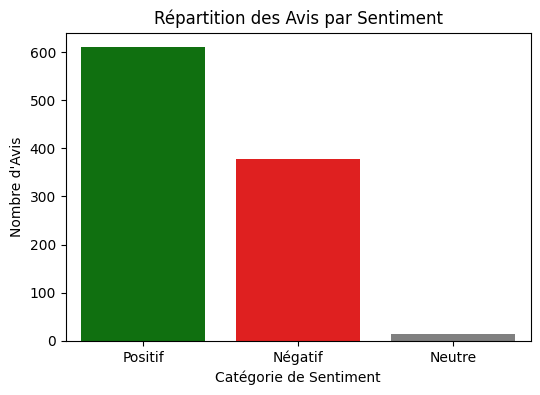

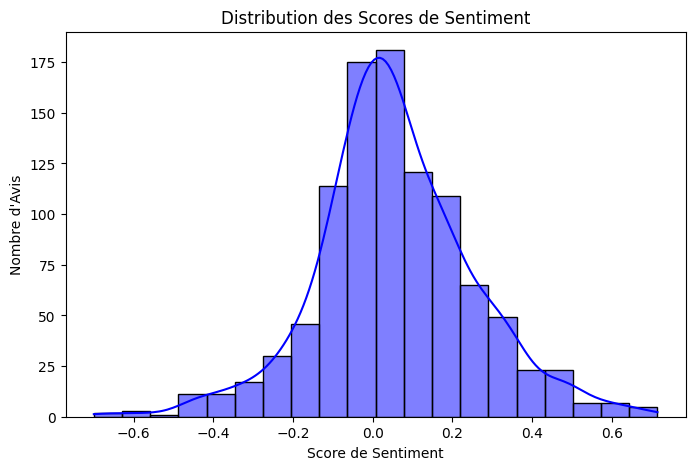

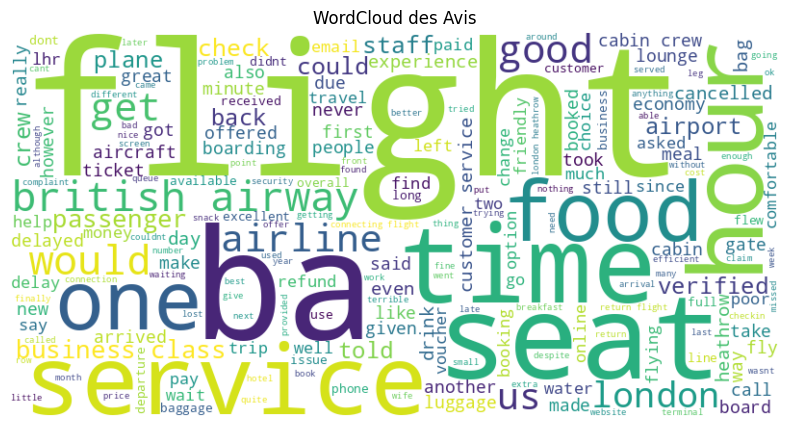

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import os



# Télécharger les stopwords si ce n'est pas encore fait
nltk.download('stopwords')

# 1️⃣ Scraping des avis de British Airways
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10  # Nombre de pages à scraper
page_size = 100
reviews = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}...")

    # Construire l'URL de la page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)

    # Vérifier si la requête a réussi
    if response.status_code != 200:
        print(f"⚠️ Erreur sur la page {i}")
        continue

    # Analyser le contenu HTML
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    # Extraire les avis
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews collectés")

# Vérification
if len(reviews) == 0:
    print("❌ Aucun avis récupéré, vérifie le site.")
    exit()

# 2️⃣ Nettoyage des données
def clean_text(text):
    text = re.sub(r"✅ Trip Verified", "", text)  # Supprimer "Trip Verified"
    text = re.sub(r"\s+", " ", text)  # Supprimer les espaces inutiles
    text = re.sub(r"[^a-zA-Z ]", "", text)  # Supprimer tout sauf les lettres et espaces
    text = text.lower().strip()  # Mettre en minuscule
    return text

reviews_cleaned = [clean_text(review) for review in reviews]

# 3️⃣ Analyse des sentiments avec TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Score entre -1 (négatif) et 1 (positif)

sentiments = [get_sentiment(review) for review in reviews_cleaned]

# 4️⃣ Classification des avis
def classify_sentiment(score):
    if score > 0.0001:
        return "Positif"
    elif score < -0.0001:
        return "Négatif"
    else:
        return "Neutre"

sentiment_labels = [classify_sentiment(score) for score in sentiments]

# 5️⃣ Sauvegarde dans un DataFrame
df = pd.DataFrame({
    "review": reviews_cleaned,
    "sentiment_score": sentiments,
    "sentiment_label": sentiment_labels
})

# Vérifier et créer le dossier "data" si besoin
os.makedirs("data", exist_ok=True)
# Sauvegarde en CSV
df.to_csv("data/BA_reviews_cleaned.csv", index=False)
print("✅ Données enregistrées dans 'data/BA_reviews_cleaned.csv'")

# 6️⃣ 📊 Visualisations des résultats

# 🔹 Répartition des avis
plt.figure(figsize=(6, 4))
sns.countplot(x=df["sentiment_label"], palette={"Positif": "green", "Neutre": "gray", "Négatif": "red"})
plt.xlabel("Catégorie de Sentiment")
plt.ylabel("Nombre d'Avis")
plt.title("Répartition des Avis par Sentiment")
plt.show()

# 🔹 Distribution des scores de sentiment
plt.figure(figsize=(8, 5))
sns.histplot(df["sentiment_score"], bins=20, kde=True, color="blue")
plt.xlabel("Score de Sentiment")
plt.ylabel("Nombre d'Avis")
plt.title("Distribution des Scores de Sentiment")
plt.show()

# 🔹 WordCloud des mots les plus fréquents
text = " ".join(df["review"])
wordcloud = WordCloud(width=800, height=400, stopwords=set(stopwords.words("english")), background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud des Avis")
plt.show()
